# Christof Jugel Master Thesis - Workflow

Three steps of the proposed workflow are implemented in this workflow. As the training of the cGAN in step 1 is a long process, parts of the resulting data are contained within the repository. Hence, **step 1** is optional.

**Step 2** implements the pasting algorithm and synthesises few example images.

**Step 3** applies the trained weights of the Image-To-Image Translation GAN onto the synthesized images to showcase its effect.

## (optional) Step 1: Conditional GAN Data Augmentation

### Setup

In [1]:
import torch
print(torch.cuda.is_available())

assert torch.cuda.is_available(), "\nNeed access to the GPU, otherwise: \n\t 1. torchlars won't install \n\t 2. will take forever even to benchmark without training"

!pip install torchlars
!pip install ninja

RuntimeError: ignored

### Mounting Drive and Cloning GIT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/POSTECH-CVLab/PyTorch-StudioGAN.git

Cloning into 'PyTorch-StudioGAN'...
remote: Enumerating objects: 6957, done.
remote: Counting objects: 100% (1759/1759), done.
remote: Compressing objects: 100% (845/845), done.
remote: Total 6957 (delta 1407), reused 994 (delta 902), pack-reused 5198
Receiving objects: 100% (6957/6957), 21.30 MiB | 27.50 MiB/s, done.
Resolving deltas: 100% (4997/4997), done.


### Preparing Data and Running the Training

In [ ]:
cd PyTorch-StudioGAN/

/content/PyTorch-StudioGAN


In [ ]:
!mkdir data

Create a subfolder **/custom/** in the **/data/** directory for your data. Inside **/custom/**, create two sub folders for each **/train/** and **/valid/**. Inside the two folder, the data is stored in a folder for each class, called **/clsX/**, starting at **/cls1/**.


---


*   docs
*   src
*   data
    *   custom
        *   train
            *    cls1
            *    cls2
            *    clsn
        *   valid
            *    cls1
            *    cls2
            *    clsn





Create a subfolder in **/src/configs/** for your project. As in the thesis, the SAGAN.json from **/src/configs/TINY_ILSVRC2012/** folder was adjusted to work on our data.

In [ ]:
cd src/

/content/PyTorch-StudioGAN/src


In [ ]:
ls

config.py  data_util.py  main.py   models/          utils/
configs/   loader.py     metrics/  sync_batchnorm/  worker.py


In [ ]:
!CUDA_VISIBLE_DEVICES=0 python3 main.py -t -e  -c "./configs/custom/SAGAN.json" --save_every 1000 --eval_type train

After the model is trained, the single heads can be generated with the following command.

In [ ]:
!CUDA_VISIBLE_DEVICES=0 python3 main.py -s -l -iv -c "./configs/custom1/SAGAN.json" --checkpoint_folder "./checkpoints/SAGAN-train-XX"   --eval_type "valid" --nrow 100 --ncol 100

## Step 2: Pasting Algorithm

In [1]:
from google.colab import drive # Mount the drive, if this has not been done before.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/MAThesis/

/content/drive/MyDrive/CJMA


In [ ]:
!mkdir /content/drive/MyDrive/MAThesis/results/SynPlot/trainA
!mkdir /content/drive/MyDrive/MAThesis/results/SynPlot/testA

In [3]:
from PIL import Image, ImageDraw, ImageFilter, ImageEnhance
import os
import numpy as np 
import glob, random
import yaml
from scipy.stats import truncnorm
import statistics

def load_bg():
    '''
    Returns a randomly chosen soil image as an Image Object.
        Returns: 
                bg (Image): soil background image
    '''
    bg = Image.open(random.choice(glob.glob(params["soil"] + "/*.png")))
    #bg = Image.open("/content/drive/MyDrive/CJMA/sample_data/soil/soil001.png").convert("RGBA")
    enhancer = ImageEnhance.Brightness(bg)
    bg = enhancer.enhance(0.7)

    bg = bg.resize((20 + params["columns"] * params["size"], 10 + params["rows"] * params["size"]))
    return bg 

def load_params(f = "params.yaml"):
    """Loads the params from the input file params.yaml

    Args:
        f (str, optional): Contains the yaml parameters. Defaults to "params.yaml".

    Returns:
        [dict]: Returns the parameters parsed into a python dictionary.
    """
    with open(f, 'r') as fd:
        return yaml.safe_load(fd)

def draw_samples(mean, std):
    """Draw the samples according the the given mean and standard deviation.

    Args:
        mean ([int]): Given mean
        std ([int]): Given std

    Returns:
        [list[int]]: [description]
    """
    X = truncnorm((0 - mean) / std, (11 - mean) / std, loc=mean, scale=std)
    re = np.zeros((params["columns"] - 2) * (params["rows"] - 2))
    for i in range(len(re)):
        re[i] = int(X.rvs())
    return re.tolist()

def plot_samples(bg, samples):
    """Plots random drawn lettuce head according to the given sample distribution on the given background.

    Args:
        bg ([Image]): Soil Background Image Object
        samples (list(int)): Drawn samples
    """
    for i in range(params["columns"]):
        for j in range(params["rows"]):
        # Case 1: First or last row or  # Case 2:  First or last column
            if j == 0 or j == params["rows"] - 1 or i == 0 or i == params["columns"] - 1:
                eval = 0
                tmp = Image.open(random.choice(glob.glob(params["heads"] + "/0/" + "/*.png"))).convert("RGBA")
            # Case 3: inside
            else:
                eval = samples.pop()
                tmp = Image.open(random.choice(glob.glob(params["heads"] + "/"  + str(int(eval)) + "/*.png"))).convert("RGBA")
            # Calculating random offset
            x_pad = np.random.randint(-params["x_offset"],params["x_offset"])
            y_pad = np.random.randint(-params["y_offset"],params["y_offset"])
            # Defining x and y coord
            x, y = i * params["size"] + x_pad, j * params["size"] + y_pad
            datas = tmp.getdata()

            newData = []
            for item in datas:
                if item[0] == 0 and item[1] == 0 and item[2] == 0:
                    newData.append((0, 0, 0, 0))
                elif item[1] < 60:
                    newData.append((0, 0, 0, 0))
                else:
                    newData.append(item)

            tmp.putdata(newData)
            w, h = bg.size
            bg.paste(tmp, (x, y), mask = tmp) 

In [4]:
ls

checkpoints/           custom/      results/
ChristofJugelMA.ipynb  params.yaml  sample_data/


In [5]:
# Load up params and background
params = load_params("params.yaml")

In [6]:
# Iterate over i (mean), j (std) and k (amount of iterations for each configuration)
for i in range(1):
    for j in range(1):
        for k in range(3):
            # Vary in the degree Lettuce heads may overlap
            params["size"] = np.random.randint(52, 64)
            #samples = draw_samples(i, j * 0.25 + 0.1)
            samples = draw_samples(7, 4 * 0.25 + 0.1)
            bg = load_bg()
            avg = round(statistics.mean(samples), 2)
            path = params["result_dir"] + params["type"] + "/" 
            filename =  str(round(avg * 10, 2)) + "-" + str(np.random.randint(10000))
            plot_samples(bg, samples)
            bg = bg.resize((660,340))
            bg.save( path + filename + ".png", "PNG")

## Step 3: Image-To-Image Translation

### 1: Mount the drive (optional)

In [ ]:
from google.colab import drive # Mount the drive, if this has not been done before.
drive.mount('/content/drive')

Mounted at /content/drive


### 2: Clone and prepare the CUT model

In [7]:
!git clone https://github.com/taesungp/contrastive-unpaired-translation.git

Cloning into 'contrastive-unpaired-translation'...
remote: Enumerating objects: 267, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 267 (delta 44), reused 30 (delta 28), pack-reused 198
Receiving objects: 100% (267/267), 17.91 MiB | 14.91 MiB/s, done.
Resolving deltas: 100% (135/135), done.


In [8]:
cd /content/drive/MyDrive/MAThesis/contrastive-unpaired-translation/

/content/drive/MyDrive/CJMA/contrastive-unpaired-translation


In [9]:
!mkdir checkpoints
!cp -r /content/drive/MyDrive/MAThesis/custom checkpoints/

Put the data for domain A and domain B of the Image-to-Image Translation in the respective folder. As in our case, the data size is rectangular, a pre-processing must be spezified for the training.

In [10]:
!pip3 install -r requirements.txt

###  (Optional) Train an image-to-image translation model
Not required to use this pipeline, as the already trained network weights can be used.



In [ ]:
!CUDA_VISIBLE_DEVICES=0 python3 train.py --name custom --model sincut --dataroot ./datasets/custom #--preprocess crop --crop_size 340

### 3: Apply the image-to-image translation

To apply the trained model to a dataset, folders testA and testB must be created. testA contains the dataset to be translated, while testB can be the copy of trainB. 

In [11]:
!mkdir datasets/custom
!cp -r /content/drive/MyDrive/MAThesis/results/SynPlot/testB datasets/custom/testB
!cp -r /content/drive/MyDrive/MAThesis/results/SynPlot/testA datasets/custom/testA
!cp -r /content/drive/MyDrive/MAThesis/results/SynPlot/trainB datasets/custom/trainB
!cp -r /content/drive/MyDrive/MAThesis/results/SynPlot/testA/ datasets/custom/trainA

In [12]:
!CUDA_VISIBLE_DEVICES=0 python3 test.py --name custom --CUT_mode CUT --preprocess none --direction AtoB --no_dropout --dataroot /content/drive/MyDrive/MAThesis/results/SynPlot --num_test 3

----------------- Options ---------------
                 CUT_mode: CUT                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/CJMA/results/SynPlot	[default: placeholder]
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
               easy_label: experiment_name               
                    epoch: latest                        
                     eval: False                         
        flip_equivariance: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: xavier                        
                 input_nc: 3                        

41.7-5046.png


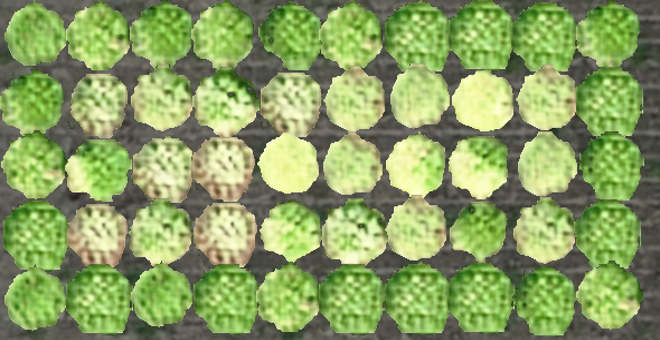

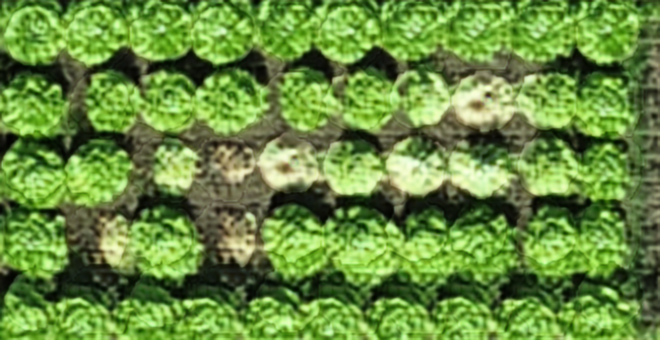

In [15]:
from IPython.display import Image, display
import os

img = os.path.basename(random.choice(glob.glob('/content/drive/MyDrive/MAThesis/contrastive-unpaired-translation/results/custom/test_latest/images/fake_B/*.png')))
print(img)

display(Image('/content/drive/MyDrive/MAThesis/results/SynPlot/testA/' + img))
display(Image('/content/drive/MyDrive/MAThesis/contrastive-unpaired-translation/results/custom/test_latest/images/fake_B/' + img))